In [1]:
#ignore
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import set_matplotlib_formats
%matplotlib inline

In [19]:
#ignore
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer

from sklearn.calibration import CalibratedClassifierCV, calibration_curve

set_matplotlib_formats('svg')

In [3]:
loans = pd.read_csv('lending_club_clean.csv')
loans.head()

,loan_amnt,annual_inc,open_acc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,term,grade,emp_length,home_ownership,purpose,defaulted
0,10000.0,49200.0,10.0,20.00,0.0,1.0,35.0,0.0,5598.0,21.00,37.0,0.0,36,C,10,RENT,other,False
1,3000.0,80000.0,15.0,17.94,0.0,0.0,38.0,0.0,27783.0,53.90,38.0,0.0,60,B,1,RENT,other,False
2,6000.0,84000.0,4.0,18.44,2.0,0.0,8.0,0.0,0.0,37.73,14.0,0.0,36,B,1,MORTGAGE,medical,False
3,5000.0,50004.0,14.0,13.97,3.0,0.0,20.0,0.0,4345.0,59.50,22.0,0.0,60,D,2,RENT,other,True
4,5000.0,24044.0,8.0,11.93,0.0,0.0,45.0,0.0,2224.0,29.30,16.0,0.0,36,A,2,RENT,debt_consolidation,False


In [4]:
#ignore
#sns.pairplot(loans.select_dtypes(include=[np.number]));

In [5]:
#ignore
loans.pub_rec_bankruptcies.value_counts()

0.0    8861
1.0     499
2.0       2
Name: pub_rec_bankruptcies, dtype: int64

In [6]:
#ignore
if 'term' in loans.columns:
    loans['term_5yrs'] = (loans['term'] == 60).astype(bool)
    loans.drop('term', axis=1, inplace=True)
    
loans['emp_length'] = loans['emp_length'].astype(float)

if 'pub_rec_bankruptcies' in loans.columns:
    loans['has_bankruptcy'] = (loans['pub_rec_bankruptcies'] > 0).astype(bool)
    loans.drop('pub_rec_bankruptcies', axis=1, inplace=True)

In [7]:
#ignore
feature_list = list(loans.select_dtypes(include=[np.number, bool]).columns)
features = loans[feature_list].drop('defaulted', axis=1)
target = loans.defaulted

In [8]:
#ignore
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42)

In [9]:
from sklearn.linear_model import LogisticRegression

In [10]:
feature_skew = X_train.select_dtypes(include=[np.number]).skew()

In [11]:
log_features = feature_skew[abs(feature_skew) > 0.9].index
scale_features = [name for name in feature_skew.index if name not in log_features]
boolean_features = X_train.select_dtypes(exclude=[np.number]).columns

In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ('log', FunctionTransformer(np.log1p, validate=False), log_features),
        ('scale', StandardScaler(), scale_features)],
    remainder='passthrough')

In [64]:
log_reg = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('logisitic', LogisticRegression(C=8, solver='lbfgs', max_iter=10000))
])

log_reg_1 = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('rfc', RandomForestClassifier(n_estimators=100, max_depth=6))
])

log_reg_1.fit(X_train, y_train);

In [65]:
log_reg.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preprocess', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('log', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<ufunc 'log1p'>, inv_kw_args=None, inverse_func=None,
    ...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [66]:
log_reg.score(X_train, y_train)

0.837202677681242

In [67]:
predict_prob = log_reg.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, predict_prob)

0.6628695737716647

In [69]:
predict_prob_1 = log_reg_1.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, predict_prob_1)

0.772209304405373

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d4e3a58>]],
      dtype=object)

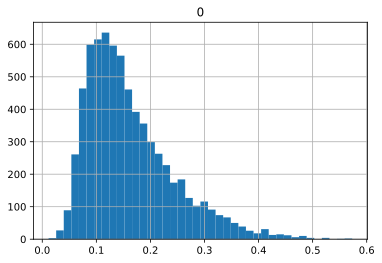

In [70]:
pd.DataFrame(predict_prob).hist(bins=40)

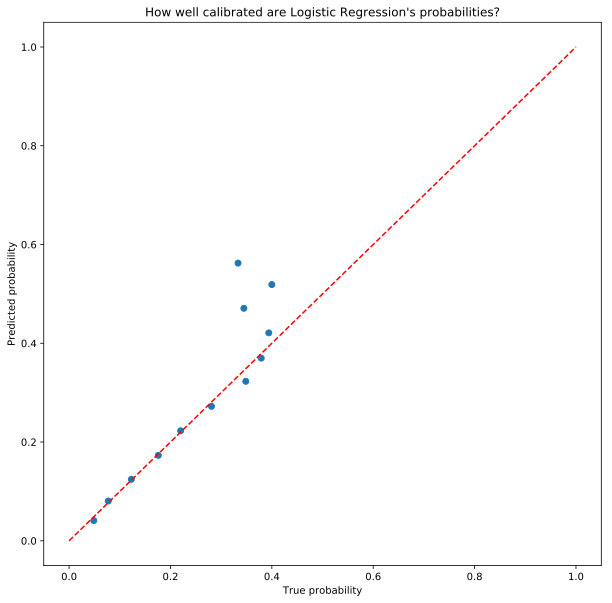

In [71]:
plt.figure(figsize=(10,10))

predict_prob = log_reg.predict_proba(X_train)[:, 1]
prob_true, prob_predict = calibration_curve(y_train, predict_prob, n_bins=20)

plt.plot(prob_true, prob_predict, 'o')
plt.plot([0,1], [0, 1], 'r--')

plt.xlabel('True probability')
plt.ylabel('Predicted probability')
plt.title('How well calibrated are Logistic Regression\'s probabilities?');


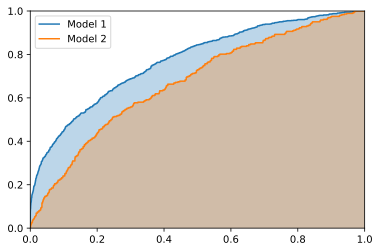

In [75]:
fpr, tpr, _ = roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])
fpr1, tpr1, _ = roc_curve(y_train, log_reg_1.predict_proba(X_train)[:, 1])


plt.plot(fpr1, tpr1, label='Model 1')
plt.fill(list(fpr1) + [1], list(tpr1) + [0], alpha=0.3)

plt.plot(fpr, tpr, label='Model 2')
plt.fill(list(fpr) + [1], list(tpr) + [0], alpha=0.3)


plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.savefig('comparing_models.png')